In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys,os,time
import numpy as np
import rasterio
from rasterio.windows import Window
import matplotlib.pyplot as plt
import skimage.measure
import scipy
from scipy.spatial.distance import euclidean
from scipy.signal import fftconvolve
import pandas as pd
import pickle
from sklearn.feature_extraction.image import extract_patches_2d
import cv2
import torch
import torch.nn as nn
import torchvision
from scipy.signal import fftconvolve
from sklearn.preprocessing import OneHotEncoder

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
p = pd.read_csv("big_lc_paths.csv", header=None)
paths = p[0].tolist()
ds = 4
save_path = "preprocessed_lc"+str(ds)+"/"
'''
0       ???    BLACK  UNUSED
1       FOREST GREEN
2       WATER  BLUE
3       FIELD  BROWN
4       OCEAN  ORANGE
5       BARREN YELLOW
6       BUILT  PINK
'''
palette = np.array([[0,0,0],[0,153,51],[0,102,255],[153,102,51],[255,153,0],[255,255,0],[204,102,153]])

def fn(i):
    return paths[i].replace('/','-')[:-7]

def disp(pic):
    plt.figure(figsize=(6,6))
    plt.imshow(pic)
    plt.axis('off')
    plt.show()
    plt.close()

def unonehot(pic):
    return np.argmax(np.rollaxis(pic,0,3),axis=2)
    
def data_conglomerate(num):
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    ohe = OneHotEncoder(n_values=7,sparse=False)
    maxx_ds = 7800//ds
    maxy_ds = 6400//ds
    total = np.zeros((num,7,maxx_ds,maxy_ds),dtype=np.float16)
    for i in range(num):
        lc_tile = rasterio.open('/mnt/blobfuse/resampled-lc/'+paths[i],'r')
        lc = np.squeeze(lc_tile.read())
        lc_tile.close()
        lc[lc==1]=10
        lc[lc==2]=1
        lc[lc==10]=2
        lc[lc==4]=0
        lc[lc==15]=4
        reduced = skimage.measure.block_reduce(lc,(ds,ds),np.max)
        fit = ohe.fit_transform(np.reshape(reduced,(-1,1)))
        tile = np.reshape(np.rollaxis(fit,1,0),(7,reduced.shape[0],reduced.shape[1])).astype(np.float16)
        tile[tile==0] = -1
        tile = np.pad(tile,((0,0),(0,maxx_ds-tile.shape[1]),(0,maxy_ds-tile.shape[2])),mode='constant')
        total[i] = tile
    path_im = save_path + 'total.npz'
    np.savez_compressed(path_im,a=total)
    print(total.shape)
    print(os.stat(path_im).st_size/1024**2)
    
    
def ds_data(num):    
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    space = 0.
    s = float(time.time())
    ohe = OneHotEncoder(n_values=7,sparse=False)
    for i in range(num):
        if (i%5==4):
            print("Tile %i of %i. Time: %.2f s. Space: %.2f MB" % (i+1,num,float(time.time())-s,space/1024**2))
        lc_tile = rasterio.open('/mnt/blobfuse/resampled-lc/'+paths[i],'r')
        lc = np.squeeze(lc_tile.read())
        lc_tile.close()
        lc[lc==1]=10
        lc[lc==2]=1
        lc[lc==10]=2
        lc[lc==4]=0
        lc[lc==15]=4
        reduced = skimage.measure.block_reduce(lc,(ds,ds),np.max)
        fit = ohe.fit_transform(np.reshape(reduced,(-1,1)))
        tile = np.reshape(np.rollaxis(fit,1,0),(7,reduced.shape[0],reduced.shape[1])).astype(np.float16)
        tile[tile==0] = -1
        path_im = save_path + fn(i)+'.npz'
        np.savez_compressed(path_im,a=tile)
        space += os.stat(path_im).st_size
    fin_time = float(time.time())-s
    fin_size = space/1024**2
    print("Finished! Time: %.2f s. Space: %.2f MB" % (fin_time,fin_size))
    print("Averaged %.3f seconds, %.0f KB per tile" % (fin_time/num,1024*fin_size/num))

In [21]:
ds_data(50)

Tile 5 of 50. Time: 14.69 s. Space: 4.40 MB
Tile 10 of 50. Time: 31.52 s. Space: 9.68 MB
Tile 15 of 50. Time: 47.74 s. Space: 14.95 MB
Tile 20 of 50. Time: 63.13 s. Space: 20.06 MB
Tile 25 of 50. Time: 78.91 s. Space: 25.17 MB
Tile 30 of 50. Time: 94.48 s. Space: 30.13 MB
Tile 35 of 50. Time: 109.61 s. Space: 35.13 MB
Tile 40 of 50. Time: 125.01 s. Space: 40.09 MB
Tile 45 of 50. Time: 139.87 s. Space: 44.99 MB
Tile 50 of 50. Time: 154.30 s. Space: 49.80 MB
Finished! Time: 157.22 s. Space: 50.81 MB
Averaged 3.144 seconds, 1041 KB per tile


In [13]:
%%time
data_conglomerate(50)

(50, 7, 1950, 1600)
53.169477462768555
CPU times: user 1min 45s, sys: 12 s, total: 1min 57s
Wall time: 2min 20s


In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
tiles = np.load(save_path+'total.npz')['a']
all_tiles = torch.from_numpy(tiles).type(torch.float16).to(device)

In [5]:
def conv_lookup(query,num_tiles,nns,out_path,to_save):
    time0 = float(time.time())
    size_ds = query.shape[2]
    some_tiles = all_tiles[num_tiles]
    query_t = torch.from_numpy(query).type(torch.float16).to(device)
    a = torch.squeeze(nn.functional.conv2d(some_tiles,query_t))
    results = {}
    for i in range(nns):
        dist, amax = a.flatten().max(0)
        (t,z1,z2) = np.unravel_index(amax,(a.shape))
        a[t,z1-size_ds//2:z1+size_ds//2,z2-size_ds//2:z2+size_ds//2]=0
        a[t,z1,z2] = 0
        results[-dist-np.random.random()/10000] = [t,z1,z2]
    del a
    torch.cuda.empty_cache()
    time1 = float(time.time())-time0
    print("Searched in %.1f seconds (%.2f seconds/tile)" % (time1,time1/len(num_tiles)))
    for key in list(results):
        curr = results[key]
        #tile = unonehot(np.load(save_path+fn(curr[0])+'.npz')['a'])
        x_ds, y_ds = curr[1],curr[2]
        curr_tile = tiles[curr[0],:,x_ds:x_ds+size_ds,y_ds:y_ds+size_ds]
        results[key].append(unonehot(curr_tile))
    grid_size = min(nns,len(results.keys()))
    df = pd.DataFrame()
    cols = int(np.sqrt(grid_size))
    rows = grid_size//cols
    grid_size = rows*cols
    new_cols = cols*2+1
    keys_sorted = sorted(results.keys())
    fig = plt.figure(figsize=(new_cols*8,rows*8))
    all_results, all_results_naip, all_dists = [], [], []
    for i in range(grid_size):
        key = keys_sorted[i]
        curr = results[key]
        acc = np.round(-key*100/size_ds**2/7,3)
        j = 1+i%cols+new_cols*(i//cols)
        if to_save:
            fig.add_subplot(rows, new_cols, j)
            plt.axis('off')
            plt.imshow(palette[curr[3]])
            plt.title("Tile %i at (%i,%i), %.1f%% accuracy" % (curr[0],curr[1],curr[2],acc))
            with rasterio.open("/mnt/blobfuse/esri-naip/"+fn(curr[0]).replace('-','/')+".mrf") as src:
                naip_tile = src.read([1,2,3],window=Window(curr[2]*ds,curr[1]*ds,size_ds*ds,size_ds*ds))
            naip = np.rollaxis(naip_tile,0,3)
            j += cols+1
            fig.add_subplot(rows, new_cols, j)
            plt.axis('off')
            plt.imshow(naip)
            plt.title("Tile %i at (%i,%i), %.1f%% accuracy" % (curr[0],ds*curr[1],ds*curr[2],acc))
            df = df.append(pd.DataFrame([curr[0],acc]).transpose(),ignore_index=True)
        all_results.append(curr[3])
        #all_results_naip.append(naip)
        all_dists.append(acc)
    if to_save:
        df.to_csv(out_path+"tiles_used.csv",index=False,header=None)
        plt.savefig(out_path+"results.png")
        print("Saved %i results in %.1f seconds" %(grid_size,float(time.time())-time0-time1))
    plt.close()
    
def query_many(q,size,num_tiles,nns):
    t,x,y = q[0],q[1],q[2]
    x_ds, y_ds, size_ds = x//ds,y//ds,size//ds
    out_path = 'query_pytorch/'+'ds'+str(ds)+'/'+str(size)+','+str(t)+','+str(x)+','+str(y)+'/'
    if not os.path.exists(out_path):
        os.makedirs(out_path)
    with rasterio.open("/mnt/blobfuse/esri-naip/"+fn(t).replace('-','/')+".mrf") as src:
        naip_tile = src.read([1,2,3],window=Window(y,x,size,size))
    naip = np.rollaxis(naip_tile,0,3)
    tile = np.load(save_path+fn(t)+'.npz')['a']
    query_out = np.expand_dims(tile[:,x_ds:x_ds+size_ds,y_ds:y_ds+size_ds],axis=0).astype(np.float16)
    tile = np.argmax(np.rollaxis(tile,0,3),axis=2)
    query = tile[x_ds:x_ds+size_ds,y_ds:y_ds+size_ds]
    fig = plt.figure(figsize=(16,8))
    fig.suptitle("Tile %i at (%i,%i)" % (t,x,y))
    fig.add_subplot(121)
    plt.axis('off')
    plt.imshow(naip)
    fig.add_subplot(122)
    plt.imshow(palette[query])
    plt.axis('off')
    plt.savefig(out_path+"query.png")
    plt.close()
    print("Querying tile %i at (%i,%i)..." % (t,x,y))
    conv_lookup(query_out,num_tiles,nns,out_path,True)

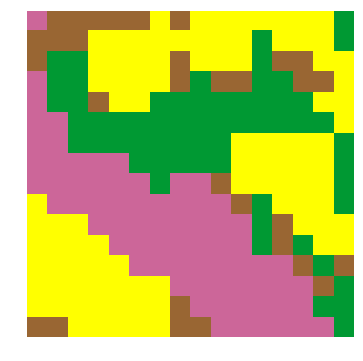

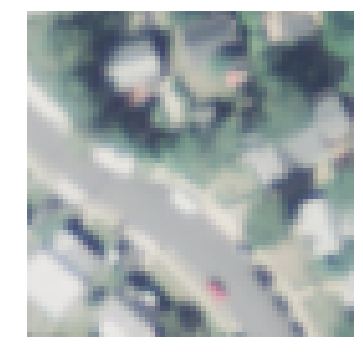

Querying tile 0 at (3000,3000)...
Searched in 60.5 seconds (2.02 seconds/tile)
Saved 20 results in 14.2 seconds


In [6]:
t,x,y,size = 0,3000,3000,64
x_ds,y_ds,size_ds=x//ds,y//ds,size//ds
tile = np.load(save_path+fn(t)+'.npz')['a']
tile = unonehot(tile)
query = tile[x_ds:x_ds+size_ds,y_ds:y_ds+size_ds]

with rasterio.open("/mnt/blobfuse/esri-naip/"+fn(t).replace('-','/')+".mrf") as src:
    naip_tile = src.read([1,2,3],window=Window(y,x,size,size))
naip = np.rollaxis(naip_tile,0,3)

disp(palette[query])
disp(naip)
query_many([t,x,y],size,np.arange(30),20)
torch.cuda.empty_cache()

In [16]:
torch.cuda.empty_cache()

In [6]:
def i_query_many(query,weight):
    time0 = float(time.time())
    size_ds = query.shape[2]
    some_tiles = all_tiles[:,:,:,:]
    #query_t = torch.from_numpy(query).type(torch.float16).to(device)
    a = torch.squeeze(nn.functional.conv2d(some_tiles,query))
    results = torch.max(torch.reshape(a,(a.shape[0],-1)),dim=1)[0]
    results /= 7.*size_ds**2/weight
    results = nn.functional.softmax(results,dim=0)
    del a
    torch.cuda.empty_cache()
    return results

In [13]:
t,x,y,size = 0,3000,3000,64
x_ds, y_ds, size_ds = x//ds,y//ds,size//ds
tile = np.load(save_path+fn(t)+'.npz')['a']
query = torch.from_numpy(np.expand_dims(tile[:,x_ds:x_ds+size_ds,y_ds:y_ds+size_ds],axis=0)).type(torch.float16).to(device)
#tile = np.argmax(np.rollaxis(tile,0,3),axis=2)
#print(i_query_many([t,x,y,size],1))
print(query.shape)
print(query.dtype)

torch.Size([1, 7, 16, 16])
torch.float16


In [14]:
%%time
print(i_query_many(query,20))
torch.cuda.empty_cache()

torch.Size([50, 1935, 1585])
tensor([1792., 1404., 1396., 1448., 1448., 1456., 1440., 1408., 1416., 1416.,
        1420., 1432., 1448., 1408., 1412., 1436., 1388., 1416., 1420., 1420.,
        1444., 1424., 1436., 1440., 1412., 1432., 1408., 1428., 1420., 1432.,
        1416., 1428., 1412., 1444., 1392., 1404., 1404., 1440., 1424., 1436.,
        1476., 1432., 1424., 1416., 1464., 1420., 1464., 1468., 1416., 1348.],
       device='cuda:0', dtype=torch.float16)
tensor([0.5439, 0.0071, 0.0065, 0.0117, 0.0117, 0.0128, 0.0106, 0.0075, 0.0081,
        0.0081, 0.0085, 0.0097, 0.0117, 0.0075, 0.0078, 0.0101, 0.0060, 0.0081,
        0.0085, 0.0085, 0.0111, 0.0089, 0.0101, 0.0106, 0.0078, 0.0097, 0.0075,
        0.0093, 0.0085, 0.0097, 0.0081, 0.0093, 0.0078, 0.0111, 0.0062, 0.0071,
        0.0071, 0.0106, 0.0089, 0.0101, 0.0159, 0.0097, 0.0089, 0.0081, 0.0138,
        0.0085, 0.0138, 0.0145, 0.0081, 0.0038],
       device='cuda:0', dtype=torch.float16)
CPU times: user 2.27 s, sys: 123 ms, tota

In [8]:
torch.cuda.empty_cache()

In [17]:
def collect_data(num,size,num_tiles,weight):
    size_ds = size//ds
    tiles = torch.zeros((num,7,size//ds,size//ds))
    print(tiles.shape)
    labels = torch.zeros((num,num_tiles))
    for i in range(num):
        if i%20==19:
            print('Creating %i of %i...' % (i+1,num))
        t = np.random.randint(50)
        x = np.random.randint(7800//ds)
        y = np.random.randint(6400//ds)
        
        tile = np.load(save_path+fn(t)+'.npz')['a']
        prepatch = np.expand_dims(tile[:,x:x+size_ds,y:y+size_ds],axis=0)
        print(prepatch.shape)
        if (prepatch.shape[2]==size_ds and prepatch.shape[3]==size_ds):
            patch = torch.from_numpy(prepatch).type(torch.float16).to(device)
            tiles[i] = patch
            labels[i] = i_query_many(patch,20)
    return tiles, labels

In [18]:
%%time
tiles, labels = collect_data(500,64,50,20)
torch.save(tiles,'query_pytorch/tiles.pt')
torch.save(labels,'query_pytorch/labels.pt')
print((os.stat('query_pytorch/tiles.pt').st_size+os.stat('query_pytorch/labels.pt').st_size)/1024**2)

torch.Size([500, 7, 16, 16])
(1, 7, 5, 16)
(1, 7, 16, 16)
(1, 7, 16, 16)
(1, 7, 16, 16)
(1, 7, 16, 16)
(1, 7, 16, 16)
(1, 7, 16, 16)
(1, 7, 16, 16)
(1, 7, 16, 16)
(1, 7, 16, 16)
(1, 7, 16, 16)
(1, 7, 16, 16)
(1, 7, 16, 16)
(1, 7, 16, 16)
(1, 7, 16, 16)
(1, 7, 16, 16)
(1, 7, 16, 16)
(1, 7, 16, 16)
(1, 7, 16, 16)
Creating 20 of 500...
(1, 7, 16, 16)
(1, 7, 16, 16)
(1, 7, 16, 2)
(1, 7, 0, 16)
(1, 7, 16, 16)
(1, 7, 16, 16)
(1, 7, 16, 16)
(1, 7, 16, 0)
(1, 7, 16, 16)
(1, 7, 16, 0)
(1, 7, 16, 0)
(1, 7, 16, 16)
(1, 7, 16, 16)
(1, 7, 16, 16)
(1, 7, 16, 16)
(1, 7, 16, 16)
(1, 7, 16, 16)
(1, 7, 16, 0)
(1, 7, 16, 16)
(1, 7, 16, 16)
Creating 40 of 500...
(1, 7, 16, 16)
(1, 7, 16, 16)
(1, 7, 16, 16)
(1, 7, 16, 0)
(1, 7, 16, 16)
(1, 7, 16, 16)
(1, 7, 16, 16)
(1, 7, 16, 16)
(1, 7, 16, 16)
(1, 7, 16, 0)
(1, 7, 16, 16)
(1, 7, 16, 16)
(1, 7, 16, 16)
(1, 7, 16, 16)
(1, 7, 16, 16)
(1, 7, 16, 16)
(1, 7, 16, 16)
(1, 7, 16, 16)
(1, 7, 16, 16)
(1, 7, 16, 16)
Creating 60 of 500...
(1, 7, 16, 16)
(1, 7, 16, 16)